# Bank Operational Dynamics Analysis Using Stochastic Methods

This notebook implements a comprehensive analysis of bank queue behaviors and operational dynamics using stochastic modeling approaches. We'll analyze how customers move through different queue states during business hours, calculate various probability metrics, and provide insights to optimize staffing and improve customer experience.

## Project Overview
This analysis consists of three main parts:
1. Markov Chain Model - Discrete-time analysis of queue states
2. Markov Process Model - Continuous-time analysis with transition rates
3. Birth-Death Process - Analysis of teller utilization

## States Definition for Part 1:
- **State 0**: No customers in queue
- **State 1**: Few customers (1-3)
- **State 2**: Moderate queue (4-7 customers)
- **State 3**: Long queue (>7 customers)
- **State 4**: Idle period (no transactions, staff handling paperwork)

In [67]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: Markov Chain Model
In this section, we implement a discrete-time Markov Chain model to analyze the bank queue dynamics.

## Data Loading and Exploration

We'll start by loading the bank data which contains hourly observations of queue states and teller activity collected over five business days. The data includes timestamps, queue states, number of active tellers, and average transaction times.

In [68]:
# Load the data
bank_data = pd.read_csv("bank_data.csv")

## Transition Probability Matrix Construction

The transition probability matrix is a fundamental component of Markov Chain analysis. It shows the probability of moving from one state to another in a single time step (in our case, one hour). Each entry P(i,j) represents the probability of transitioning from state i to state j.

We'll construct this matrix by counting transitions in our observed data and normalizing each row to get probabilities.

In [69]:
# Function to construct transition probability matrix from sequence of states
def construct_transition_matrix(states):
    """
    Construct transition probability matrix from sequence of states.
    """
    unique_states = sorted(set(states))
    n_states = len(unique_states)
    
    # Initialize transition count matrix
    transitions = np.zeros((n_states, n_states))
    
    # Count transitions
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transitions[current_state, next_state] += 1
    # Convert to probabilities (normalize rows)
    transition_probabilities = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = np.sum(transitions[i, :])
        if row_sum > 0:
            transition_probabilities[i, :] = transitions[i, :] / row_sum
    
    return transition_probabilities

# Construct transition matrix
states = bank_data['State'].values
transition_matrix = construct_transition_matrix(states)

print("Transition Probability Matrix:")
print(np.round(transition_matrix, 3))

Transition Probability Matrix:
[[0.385 0.231 0.077 0.154 0.154]
 [0.333 0.533 0.133 0.    0.   ]
 [0.125 0.5   0.25  0.125 0.   ]
 [0.2   0.    0.6   0.    0.2  ]
 [0.    0.    0.333 0.667 0.   ]]


## Steady State Analysis

In Markov Chain analysis, the steady state (or stationary distribution) represents the long-run probability of finding the system in each state after many transitions. This helps us understand the equilibrium behavior of the queue system.

We can compute this by raising the transition matrix to a high power, or by solving the system of equations πP = π where π is the steady state distribution and P is the transition matrix.

In [70]:
# Function to compute n-step transition probabilities
def matrix_power(matrix, n):
    """Compute the nth power of a matrix."""
    return np.linalg.matrix_power(matrix, n)

# Function Calculate steady state distribution
def calculate_steady_state(P):
    """Calculate steady state distribution for transition matrix P."""
    high_power=matrix_power(P, 20) # Raise to a high power
    stationary = high_power[0, :]  # First row of the high power matrix gives steady state distribution
    return stationary

# Using the above functions to calculate steady state distribution
steady_state_distribution = calculate_steady_state(transition_matrix)
print("Steady State Distribution:")
print(np.round(steady_state_distribution, 3))


Steady State Distribution:
[0.269 0.353 0.206 0.109 0.063]


## Visualization of Steady State Distribution

Visualizing the steady state distribution helps us understand the long-run behavior of the queue system at a glance. The bar chart below shows the proportion of time the system spends in each state over the long run.

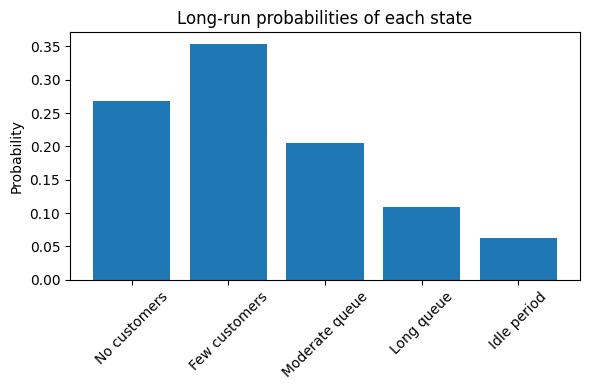

In [71]:
# Plotting the steady state distribution as a bar chart
plt.figure(figsize=(6, 4))
stationary_distribution = calculate_steady_state(transition_matrix)
states = ["No customers", "Few customers", "Moderate queue", "Long queue", "Idle period"]
plt.bar(states, stationary_distribution)
plt.title("Long-run probabilities of each state")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis Questions for Part 1

Below we address the key questions for our Markov Chain analysis:

### 1. Probability of Reaching Long Queue from Empty Queue

One key question is how quickly a bank can go from having no customers to a long queue situation. This helps in planning staff allocation and predicting busy periods. We calculate this probability for different time horizons (3 to 8 hours).

In [72]:
 # 1. Probability of reaching long queue (state 3) from empty queue (state 0)
initial_state = 0  # Empty queue
target_state = 3   # Long queue
    
print("\n1. Probability of reaching long queue from empty queue:")
for hours in range(3, 9):  # Check for 3 to 8 hours
    n_step_matrix = matrix_power(transition_matrix, hours)
    prob = n_step_matrix[initial_state, target_state]
    print(f"   After {hours} hours: {prob:.3f}")


1. Probability of reaching long queue from empty queue:
   After 3 hours: 0.129
   After 4 hours: 0.118
   After 5 hours: 0.109
   After 6 hours: 0.109
   After 7 hours: 0.108
   After 8 hours: 0.109


### 2. Probability of Long Queue at Midday

Midday (12 PM) is often a busy period for banks as customers visit during their lunch breaks. Understanding the probability of a long queue at this time helps in scheduling additional staff if needed.

In [73]:
# 2. Probability of having a long queue at 12 PM
    # First, get the distribution at opening (8 AM)
opening_distribution = np.zeros((5, 1)) 
opening_distribution[0] = 1.0  # Assume bank starts empty

    # Calculate distribution at 12 PM (4 hours after opening)
distribution_at_12pm = opening_distribution.transpose() @ matrix_power(transition_matrix, 4)
long_queue_prob_at_12pm = distribution_at_12pm[0,3]

print(f"\n2. Probability of long queue at 12 PM: {long_queue_prob_at_12pm:.4f}")


2. Probability of long queue at 12 PM: 0.1184


### 3. Expected Occurrences of Long Queue

Understanding how many times a long queue is likely to occur during a typical business day helps in resource planning and setting customer expectations.

In [74]:
# 3. Expected number of times a long queue is observed throughout the day
    # Using the stationary distribution
stationary_distribution = calculate_steady_state(transition_matrix)

    # Expected occurrences in 9 business hours
expected_long_queue_occurrences = stationary_distribution[3] * 9

print(f"\n3. Expected number of times long queue observed in one day: {expected_long_queue_occurrences:.4f}")


3. Expected number of times long queue observed in one day: 0.9824


### 4. Expected Time in Long Queue State

This metric helps understand th sojourn time spent in a long queue situation. This is important for planning staffing levels and managing customer satisfaction.

In [75]:
# 4. Expected time spent in long queue state
expected_time_in_long_queue = 1 / (1 - transition_matrix[3,3])
print(f"\n4. Expected time spent in long queue state: {expected_time_in_long_queue:.4f} hours")


4. Expected time spent in long queue state: 1.0000 hours


### 5. Long-run State Probabilities

The long-run probabilities show the equilibrium distribution of queue states. This helps understand the overall operational pattern of the bank.

In [76]:
# 5. Long-run probabilities of each state
print("\n5. Long-run probabilities of each state:")
for i, prob in enumerate(stationary_distribution):
    print(f"   State {i}: {prob:.4f}")


5. Long-run probabilities of each state:
   State 0: 0.2686
   State 1: 0.3533
   State 2: 0.2058
   State 3: 0.1092
   State 4: 0.0632


### 6. Expected Steps to First Long Queue

This analysis shows how many transitions (hours) it takes on average for the system to first reach a long queue state, starting from an empty queue. This is calculated using the fundamental matrix method for absorbing Markov chains, where we temporarily treat the target state (long queue) as an absorbing state.

In [77]:
# 6. Expected steps before first attaining long queue from initial state
# Calculate the mean first passage time (MFPT)

# Extract the transient states (excluding the absorbing state)
transient_states = list(range(len(transition_matrix)))
transient_states.remove(target_state)

# Create the Q matrix (submatrix of transient states)
Q = transition_matrix[np.ix_(transient_states, transient_states)]
print(f"\nQ matrix (transient states):\n{np.round(Q,3)}")

# Calculate the fundamental matrix N = (I - Q)^(-1)
I = np.eye(len(Q))
N = np.linalg.inv(I - Q) 
# Note: The fundamental matrix N is used to calculate the expected number of visits to transient states over the full duration of the process
print(f"\nFundamental matrix N:\n{np.round(N,3)}")

# Calculate the mean first passage time to the absorbing state
mfpt = np.sum(N[initial_state, :])  # Sum of the row corresponding to the initial state

print(f"\n6. Expected steps before first attaining long queue from empty queue: {mfpt:.3f}")


Q matrix (transient states):
[[0.385 0.231 0.077 0.154]
 [0.333 0.533 0.133 0.   ]
 [0.125 0.5   0.25  0.   ]
 [0.    0.    0.333 0.   ]]

Fundamental matrix N:
[[3.374 2.824 1.079 0.519]
 [3.176 5.305 1.486 0.489]
 [2.679 4.008 2.504 0.412]
 [0.893 1.336 0.835 1.137]]

6. Expected steps before first attaining long queue from empty queue: 7.796


### 7. Expected Time to Return to Long Queue

The mean recurrence time is the expected number of steps before the system returns to a particular state after leaving it. For long queues, this metric helps understand how frequently these high-volume situations recur.

In [78]:
# 7. Expected time before returning to long queue after leaving it
    # This is the mean recurrence time for state 3
mean_recurrence_time = 1 / stationary_distribution[3]

print(f"\n7. Expected time before returning to long queue after leaving it: {mean_recurrence_time:.4f} steps")


7. Expected time before returning to long queue after leaving it: 9.1613 steps


## Part 1 Conclusions

Based on our Markov Chain analysis of the bank's queue dynamics, we can draw several operational insights:

1. **Queue Patterns**: The bank spends approximately 26.9% of time with no customers, 35.3% with few customers, 20.6% with moderate queues, 10.9% with long queues, and 6.3% in idle periods.

2. **Critical Metrics**:
   - Long queues occur on average about once per day (0.98 expected occurrences)
   - It takes approximately 7.8 steps (hours) on average to first reach a long queue from an empty state
   - After a long queue dissipates, it takes about 9.2 steps (hours) on average before another long queue forms

3. **Operational Recommendations**:
   - Schedule additional staff around midday when the probability of long queues increases
   - Consider implementing a teller rotation system to handle the approximately 1 hour per day of long queue situations
   - Optimize staffing during periods where the bank is frequently in state 0 (no customers) or state 4 (idle)

4. **Next Steps**:
   - Further analyze the data using continuous-time Markov Process models (Part 2)
   - Implement Birth-Death Process analysis for teller utilization optimization (Part 3)

# Part 2: Markov Process Model

In this section, we'll implement a continuous-time Markov Process model to analyze the bank queue dynamics with transition rates.

## Step 1: Transition Rate Matrix
We'll construct the transition rate matrix based on the formula:

$$\lambda_{ij} = \frac{\text{Total number of transitions from state } i \text{ to state } j}{\text{Total duration (hours) spent in state } i}$$


In [79]:
def construct_transition_rate_matrix(states):
    """
    Construct transition rate matrix from sequence of states.
    """
    unique_states = sorted(set(states))
    n_states = len(unique_states)
    
    # Initialize matrices
    transitions_count = np.zeros((n_states, n_states))
    state_durations = np.zeros(n_states)
    
    # Count transitions and time spent in each state
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        
        # Count transition
        transitions_count[current_state, next_state] += 1
        
        # Add time spent in current state (assume 1 hour between observations)
        state_durations[current_state] += 1
    
    # Last state duration
    state_durations[states[-1]] += 1
    
    # Calculate transition rates (λij)
    transition_rates = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j and state_durations[i] > 0:
                transition_rates[i, j] = transitions_count[i, j] / state_durations[i]
    
    # Set diagonal elements (λii = -Σj≠i λij)
    for i in range(n_states):
        transition_rates[i, i] = -np.sum(transition_rates[i, :])
    
    return transition_rates

# Construct transition rate matrix
states = bank_data['State'].values
transition_rate_matrix = construct_transition_rate_matrix(states)

print("Transition Rate Matrix:")
print(np.round(transition_rate_matrix, 3))


Transition Rate Matrix:
[[-0.615  0.231  0.077  0.154  0.154]
 [ 0.333 -0.467  0.133  0.     0.   ]
 [ 0.111  0.444 -0.667  0.111  0.   ]
 [ 0.2    0.     0.6   -1.     0.2  ]
 [ 0.     0.     0.333  0.667 -1.   ]]


## Step 2: Analysis Using the Markov Process Model

1. **Steady State Probabilities**
2. **Mean Sojourn Times**
3. **Mean First Passage Time**


In [80]:
n_states = len(transition_rate_matrix)

# 1. Find the steady state probabilities

# Set up system of equations: π * Q = 0 and sum(π) = 1
Q = transition_rate_matrix.T

A = np.vstack((Q, np.ones(n_states)))

b = np.zeros(n_states + 1)
b[-1] = 1


# Solve the system
steady_state = np.linalg.lstsq(A, b, rcond=None)[0]

print("\n1. Steady state probabilities:")
for i, prob in enumerate(steady_state):
    print(f"   State {i}: {prob:.4f}")


1. Steady state probabilities:
   State 0: 0.2619
   State 1: 0.3444
   State 2: 0.2257
   State 3: 0.1064
   State 4: 0.0616


In [81]:
# 2. Mean sojourn times for each state
sojourn_times = np.zeros(n_states)
for i in range(n_states):
    if transition_rate_matrix[i, i] < 0:
        sojourn_times[i] = -1 / transition_rate_matrix[i, i]
    else:
        sojourn_times[i] = float('inf')  # If no transitions out, sojourn time is infinite

print("\n2. Mean sojourn times for each state:")
for i, time in enumerate(sojourn_times):
    print(f"   State {i}: {time:.4f} hours")


2. Mean sojourn times for each state:
   State 0: 1.6250 hours
   State 1: 2.1429 hours
   State 2: 1.5000 hours
   State 3: 1.0000 hours
   State 4: 1.0000 hours


In [82]:
# 3. Mean first passage time from long queue to each other state
long_queue_state = 3
mean_first_passage_times = {}

for target in range(n_states):
    if target == long_queue_state:
        mean_first_passage_times[target] = 0
        continue
    
    # Set up system of equations based on theory of continuous-time Markov chains
    # For MFPT from state i to state j (target), denoted as m_ij, we solve:
    # Σ(k≠j) λ_ik * m_kj = -1 for all i≠j
    # with boundary condition m_jj = 0
    
    A = np.zeros((n_states, n_states))
    b = np.zeros(n_states)
    
    for i in range(n_states):
        if i == target:
            # Boundary condition: m_jj = 0 (time to reach j when already at j is 0)
            A[i, i] = 1
            b[i] = 0
        else:
            # For i≠j, implement the equation Σ(k≠j) λ_ik * m_kj = -1
            for k in range(n_states):
                if k != target:  # k≠j condition (exclude target state from sum)
                    # Add λ_ik coefficient for m_kj
                    A[i, k] = transition_rate_matrix[i, k]
            
            # Right-hand side is -1
            b[i] = -1
    
    # Solve the system of equations
    try:
        x = np.linalg.solve(A, b)
        mean_first_passage_times[target] = x[long_queue_state]
    except np.linalg.LinAlgError:
        mean_first_passage_times[target] = "N/A (singular matrix)"

print("\n3. Mean first passage time from long queue to each state:")
for state, time in mean_first_passage_times.items():
    if state != long_queue_state:
        if isinstance(time, float):
            print(f"   To State {state}: {time:.4f} hours")
        else:
            print(f"   To State {state}: {time}")


3. Mean first passage time from long queue to each state:
   To State 0: 4.9516 hours
   To State 1: 4.7618 hours
   To State 2: 2.5659 hours
   To State 4: 14.1662 hours


# Part 3: Birth-Death Process

In this section, we'll analyze teller utilization using a Birth-Death Process model.

## Step 1: Transition Rate Matrix for Tellers
Assumptions:
- The number of states equals the maximum number of tellers (N)
- Service times follow an exponential distribution

[Implementation to be added]

## Step 2: Analysis Using the Birth-Death Process Model

1. **Long-Run Probabilities**
2. **Likelihood of All Tellers Busy**
3. **Expected Time in Each State**
4. **Expected Time to Full Occupancy**
5. **Impact of Increasing Tellers**
6. **Frequency of Full Capacity**

[Implementation to be added]

# Overall Conclusions and Recommendations

This section will synthesize insights from all three modeling approaches to provide comprehensive recommendations for bank operations.

[To be completed after implementing all three parts]